# 1. Thêm các thư viện cần thiết

Ở đây, chúng ta sẽ sử dụng `opencv2` cho việc xử lý hình ảnh, `matplotlib` để show ảnh, và một số thư viện phụ trợ khác.

In [121]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from tqdm import tqdm

# 2. Tải hình ảnh để sử dụng

In [26]:
# Tạo biến xác định ảnh được chọn
split = 'Finding/2'

Đọc ảnh cần tìm vật và chọn thử 1 đồ vật để hiển thị xem chúng như thế nào.

In [27]:
image_2 = cv2.imread(f'{split}/image.png') # Ảnh cần tìm vật
template_2 = cv2.imread(f'{split}/t1.png') # Template được chọn

In [110]:
def show_images(images, figsize=(10, 10), plot_size=None):
    """
    Hiển thị một hoặc nhiều ảnh bằng Matplotlib.

    Nếu chỉ có một ảnh, hàm sẽ hiển thị ảnh duy nhất đó.
    Nếu có nhiều ảnh, hàm sẽ hiển thị theo lưới (grid) con dựa trên `plot_size` (nếu được cung cấp).

    Args:
        images (list of np.ndarray): Danh sách ảnh để hiển thị.
        figsize (tuple of int, optional): Kích thước của figure. Mặc định là (10, 10).
        plot_size (tuple of int, optional): Kích thước lưới hiển thị, dạng (rows, cols).
            Nếu không được truyền vào, ảnh sẽ được hiển thị tuần tự trên các subplot liên tiếp.

    Returns:
        None: Hàm không trả về giá trị, chỉ hiển thị ảnh bằng matplotlib.
    """
    
    plt.figure(figsize=figsize)
    
    # If you want to show only one image.
    if not isinstance(images, list):
        plt.imshow(images)
        plt.axis('off')
        return
    
    # Else
    for i, image in enumerate(images):
        if len(image.shape) > 2:
            image = image[:,:,::-1]
        if plot_size is not None:
            plt.subplot(plot_size[0], plot_size[1], i + 1)    
        plt.imshow(image)
        plt.axis('off')
    if plot_size is not None:
        for i in range(len(images), plot_size[0] * plot_size[1]):
            plt.subplot(plot_size[0], plot_size[1], i + 1)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

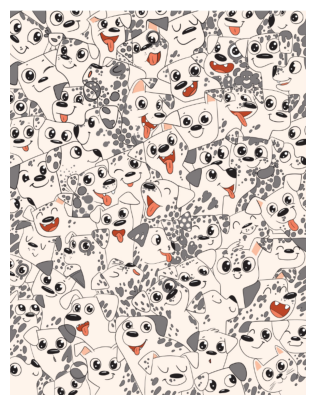

In [61]:
to_show = image_2[:,:,::-1]

show_images(to_show, figsize=(8, 5))

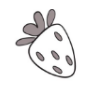

In [62]:
to_show = template_2[:,:,::-1]

show_images(to_show, figsize=(1, 1))

Bây giờ hãy thử lấy ra toàn bộ template cần tìm và hiển thị chúng.

In [31]:
def get_all_templates(dir, num_temps, name_tag='t'):
    """
    Đọc một loạt file ảnh từ thư mục chỉ định và trả về danh sách các ảnh (templates).

    Args:
        dir (str): Đường dẫn đến thư mục chứa ảnh.
        num_temps (int): Số lượng ảnh (templates) cần lấy.
        name_tag (str, optional): Tiền tố dùng để tạo tên file. Mặc định là 't'.

    Returns:
        list: Danh sách các ảnh (templates) dưới dạng numpy array.
    """
    templates = list()
    for i in range(num_temps):
        path = os.path.join(dir, f"{name_tag}{i+1}.png")
        template = cv2.imread(path)
        templates.append(template)
    return templates

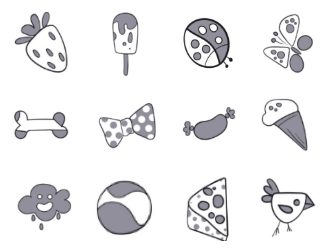

In [32]:
templates_2 = get_all_templates(split, 12)
show_images(templates_2, plot_size=(3, 4), figsize=(4, 3))

Ở trên là ảnh ở dạng RGB. Tuy nhiên ta nên chuyển ảnh sang dạng ảnh mức xám, vì:

1. Tăng tốc độ xử lý: Ảnh màu có 3 kênh (RGB), trong khi ảnh xám chỉ có 1 kênh, giúp giảm tài nguyên tính toán.  
2. Ổn định hơn với thay đổi màu sắc: Grayscale giúp tập trung vào hình dạng thay vì màu sắc, tránh nhiễu do thay đổi ánh sáng.  
3. Độ tương phản quan trọng hơn màu sắc: Các phương pháp so khớp dựa vào cường độ pixel thay vì màu sắc, nên ảnh xám cho kết quả chính xác hơn.  

Ta chỉ giữ ảnh màu khi cần so khớp theo từng kênh hoặc màu sắc là yếu tố quan trọng.

In [33]:
def convert_color(images, color='rgb'):
    """
    Chuyển đổi không gian màu cho một ảnh hoặc danh sách ảnh sang không gian màu chỉ định.

    Args:
        images (numpy.ndarray | list): Ảnh đầu vào hoặc danh sách ảnh.
        color (str, optional): Kiểu màu muốn chuyển, như 'rgb' hoặc 'gray'. Mặc định là 'rgb'.

    Returns:
        numpy.ndarray | list: Ảnh (hoặc danh sách ảnh) sau khi chuyển đổi màu.
    """
    if not isinstance(images, list):
        return cv2.cvtColor(images, color)
    
    res = []
    for image in images:
        res.append(cv2.cvtColor(image, color))
    return res

In [34]:
# Chuyển sang ảnh mức xám
gray_image_2 = convert_color(image_2, cv2.COLOR_BGR2GRAY)
gray_template_2 = convert_color(template_2, cv2.COLOR_BGR2GRAY)

# 3. Finding

Yêu cầu của bài toán là tìm vật thể trong ảnh, vì vậy chúng ta sẽ hướng đến các phương pháp matching để tìm ra vị trí của vật thể.

Mô hình hóa: $$F(I, t) = (x, y, x', y')$$
Trong đó:
 - I: hình ảnh chứa vật cần tìm
 - t: vật cần tìm
 - x, y: tọa độ góc trên bên trái, xét trong I
 - x', y': tọa độ góc dưới bên phải, xét trong I

## 3.1 Thử cách đơn giản

Đầu tiên, chúng ta sẽ thử dùng template matching mà không điều chỉnh hay xử lý gì thêm.

In [35]:
def match_template(image, template, meth):
    """
    Thực hiện template matching với nhiều phương pháp khác nhau trên một ảnh duy nhất.
    Trả về danh sách kết quả, mỗi kết quả gồm thông tin:
      - top_left, bottom_right: tọa độ bounding box
      - min_val, max_val: giá trị thu được từ minMaxLoc
      - best_value: giá trị quyết định match tốt nhất (tùy vào phương pháp)
      - method: phương pháp matching
    """
    h, w = template.shape[:2]

    method = getattr(cv2, meth)
    res = cv2.matchTemplate(image, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # Xác định góc trên/trái (top_left) và góc dưới/phải (bottom_right)
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        # Với SQDIFF, điểm match tốt nhất là min_val
        top_left = min_loc
        best_value = min_val
    else:
        # Với các phương pháp còn lại, điểm match tốt nhất là max_val
        top_left = max_loc
        best_value = max_val

    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    result = {
        "top_left": top_left,
        "bottom_right": bottom_right,
        "min_val": min_val,
        "max_val": max_val,
        "best_value": best_value,
        "method": meth
    }

    return result

In [36]:
def draw_bounding_box(image, match_result, color=(0, 0, 0), in_place=False):
    """
    Vẽ bounding box trực tiếp lên ảnh dựa trên kết quả match_result
    rồi trả về ảnh kết quả. Không sử dụng matplotlib để hiển thị.

    Args:
        image (np.ndarray): Ảnh gốc (BGR hoặc grayscale).
        match_result (dict | list[dict]):
            - dict: dạng {
                 "top_left": (x, y),
                 "bottom_right": (x, y),
                 "min_val": float,
                 "max_val": float,
                 "best_value": float,
                 "method": str (tuỳ chọn)
              }
            - list[dict]: danh sách các dict giống trên.

    Returns:
        np.ndarray: Ảnh đã được vẽ bounding box (cùng kích thước với ảnh gốc).
    """
    import cv2

    # Nếu match_result là dict, gói thành danh sách để nạp vòng lặp
    if isinstance(match_result, dict):
        match_result = [match_result]

    if in_place:
        image_to_draw = image
    else:
        image_to_draw = image.copy()

    # Vẽ bounding box cho từng dict
    for res in match_result:
        top_left = res["top_left"]
        bottom_right = res["bottom_right"]
        cv2.rectangle(image_to_draw, top_left, bottom_right, color, 4)

    return image_to_draw

Thử thực hiện matching đơn giản với SQDIFF (sum of squared difference), CCOEFF (correlation coefficient) và CCORR (cross-correlation) để đánh giá kết quả.

<Figure size 200x200 with 0 Axes>

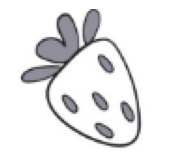

<Figure size 600x1000 with 0 Axes>

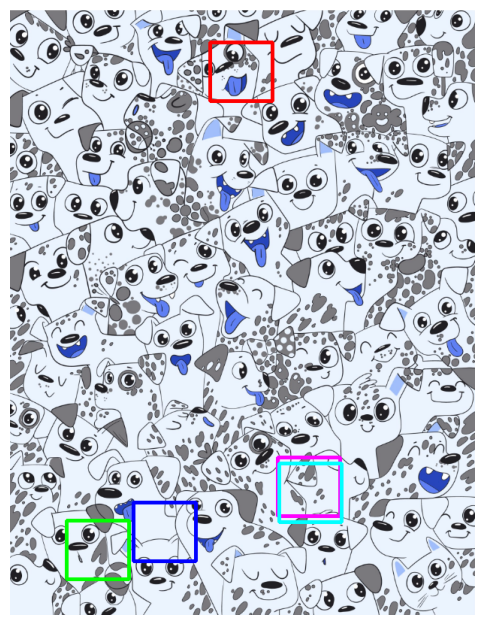

In [53]:
methods = [
    "TM_CCOEFF",
    "TM_CCOEFF_NORMED",
    "TM_CCORR",
    "TM_CCORR_NORMED",
    "TM_SQDIFF",
    "TM_SQDIFF_NORMED"
]

img_res = image_2.copy()

# Một số màu ví dụ
colors = [
    (255, 0, 0),   # Đỏ
    (0, 255, 0),   # Xanh lá
    (0, 0, 255),   # Xanh dương
    (255, 255, 0), # Vàng
    (255, 0, 255), # Hồng
    (0, 255, 255)  # Xanh biển
]

for i, method in enumerate(methods):
    match_result = match_template(gray_image_2, gray_template_2, method)
    color = colors[i]
    img_res = draw_bounding_box(img_res, match_result, color, in_place=True)
   
show_images(template_2, figsize=(2, 2)) 
show_images(img_res, figsize=(6, 10))

Có thể thấy rằng kết quả không tốt chút nào, toàn bộ các phương pháp đều tìm sai. Vậy cần phải xác định được nguyên nhân.

| | Nguyên nhân | Giải pháp đề xuất |
|-|-------------|-------------------|
|1| Sự khác biệt giữa kích thước của vật cần tìm với kích thước của vật đó trong ảnh, do đề bài và quá trình cắt ảnh | Sử dụng multiscale template matching |
|2| Sự khác biệt về vùng xung quanh vật trong template và trong image | Sử dụng masking để loại bỏ vùng không cần thiết |

## 3.2 Cải tiến cách vừa rồi

Từ những vấn đề vừa xác định ở trên, tiếp theo chúng ta sẽ thực hiện masking (xóa bỏ background của template) và sau đó thực hiện template matching trên nhiều scale khác nhau của template đó.

<Figure size 400x400 with 0 Axes>

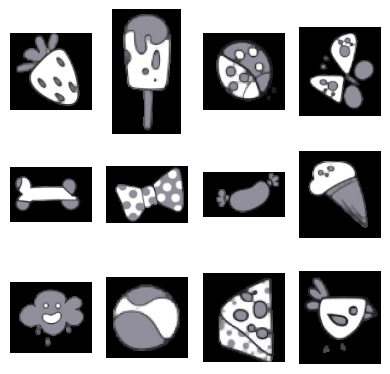

In [75]:
def remove_bg(templates):
    """
    Loại bỏ background của danh sách vật thể (templates) bằng kỹ thuật floodFill và xử lý ảnh cơ bản.

    Args:
        templates (list of np.ndarray): Danh sách các ảnh đầu vào cần loại bỏ nền.

    Returns:
        list of np.ndarray: Danh sách các ảnh sau khi loại bỏ nền.
    """
    removed_bg_templates = list()

    for template in templates:
        # Tạo bản sao để tránh làm thay đổi ảnh gốc
        filled_color_template = template.copy()

        # Bước 1: Chuyển ảnh sang xám
        gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape[:2]

        # Bước 2: Tạo mask bằng ngưỡng và đảo mask
        _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        mask = cv2.bitwise_not(mask)

        # Bước 3: Tạo mask mở rộng để hỗ trợ floodFill
        mask_expanded_original = np.zeros((h+2, w+2), np.uint8)
        mask_expanded_original[1:-1, 1:-1] = mask

        # Bước 4: Tách kênh màu (B, G, R)
        b, g, r = cv2.split(template)

        # Áp dụng floodFill trên từng kênh để xóa nền
        mask_expanded = mask_expanded_original.copy()
        cv2.floodFill(b, mask_expanded, (0, 0), 0, loDiff=20, upDiff=20)

        mask_expanded = mask_expanded_original.copy()
        cv2.floodFill(g, mask_expanded, (0, 0), 0, loDiff=20, upDiff=20)

        mask_expanded = mask_expanded_original.copy()
        cv2.floodFill(r, mask_expanded, (0, 0), 0, loDiff=20, upDiff=20)

        # Bước 5: Gộp các kênh sau khi xử lý
        filled_color_template = cv2.merge((b, g, r))

        # Bước 6: Áp dụng phép mở (morphological opening) để loại bỏ nhiễu
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        filled_color_template = cv2.morphologyEx(filled_color_template, cv2.MORPH_OPEN, kernel)
        
        removed_bg_templates.append(filled_color_template)
        
    return removed_bg_templates

removed_bg_templates_2 = remove_bg(templates_2)
show_images(removed_bg_templates_2, plot_size=(3, 4), figsize=(4, 4))

In [ ]:
def remove_bg_grabcut(templates, bgd_model_iters=5):
    """
    Loại bỏ phông nền bằng GrabCut cho danh sách ảnh (templates).
    GrabCut thường cho kết quả chính xác hơn floodFill trong nhiều trường hợp.

    Args:
        templates (list of np.ndarray): Danh sách ảnh BGR cần tách nền.
        bgd_model_iters (int): Số lần lặp cho mô hình nền (thường 5 đến 10).

    Returns:
        list of np.ndarray: Danh sách ảnh đã được tách nền (nền chuyển thành đen).
    """
    results = []
    for img in templates:
        if img is None:
            results.append(None)
            continue

        # Lấy kích thước ảnh
        h, w = img.shape[:2]

        # Tạo mask rỗng
        grabcut_mask = np.zeros((h, w), np.uint8)

        # Chuẩn bị 2 mô hình GMM cho GrabCut
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)

        # Tạo vùng bao (rectangle) gần như khớp toàn bộ ảnh
        rect = (1, 1, w-2, h-2)

        # Áp dụng GrabCut
        # mode=GC_INIT_WITH_RECT: khỏi tạo bằng rectangle
        cv2.grabCut(img, grabcut_mask, rect, bgd_model, fgd_model, bgd_model_iters, cv2.GC_INIT_WITH_RECT)

        # Tạo mask foreground = 1 hoặc 3 => vùng nền = 0,2 => gán 0
        mask_fg = np.where((grabcut_mask==2)|(grabcut_mask==0), 0, 1).astype('uint8')

        # Nhân mask_fg vào ảnh gốc => giữ foreground, nền thành đen
        img_nobg = cv2.bitwise_and(img, img, mask=mask_fg)

        results.append(img_nobg)

    return results


<Figure size 600x600 with 0 Axes>

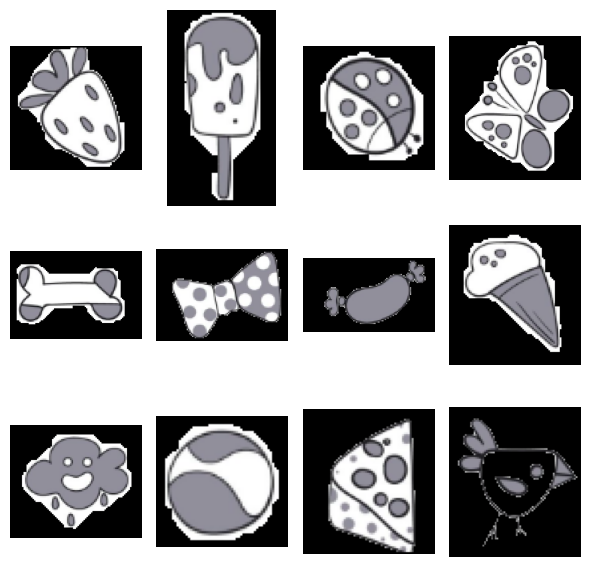

<Figure size 600x600 with 0 Axes>

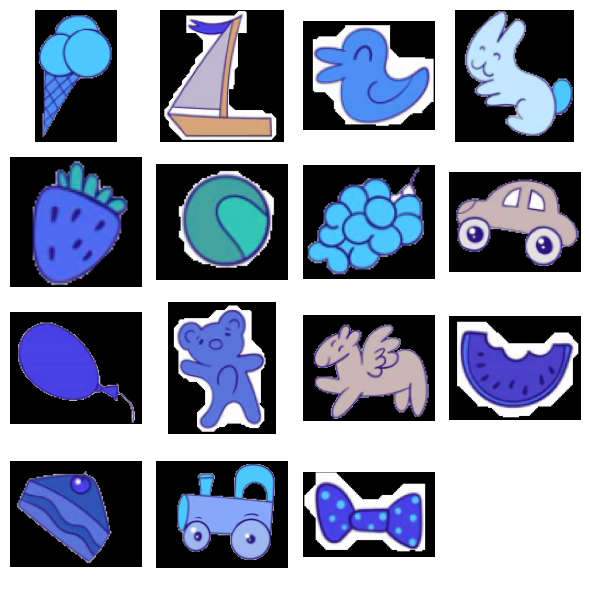

<Figure size 600x600 with 0 Axes>

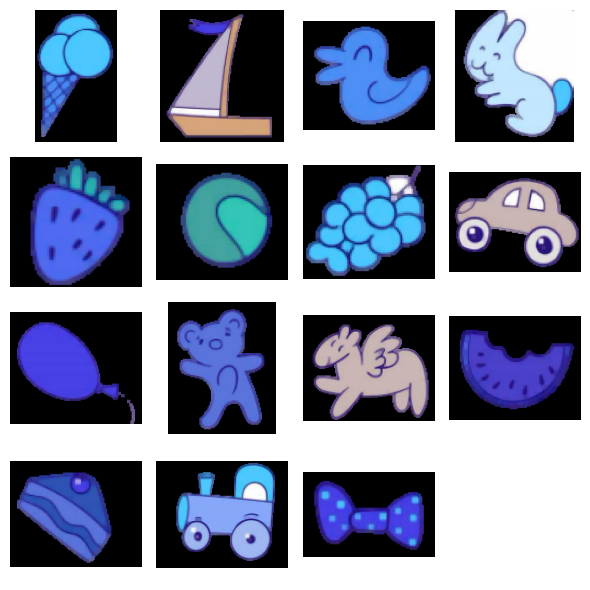

In [97]:
removed_bg_templates_2 = remove_bg_grabcut(templates_2, bgd_model_iters=5)
show_images(removed_bg_templates_2, plot_size=(3, 4), figsize=(6, 6))

image_1 = cv2.imread('Finding/1/image.png')
gray_image_1 = convert_color(image_1, cv2.COLOR_BGR2GRAY)
templates_1 = get_all_templates('Finding/1', 15)
removed_bg_templates_1_1 = remove_bg_grabcut(templates_1, bgd_model_iters=5)
show_images(removed_bg_templates_1_1, plot_size=(4, 4), figsize=(6, 6))

templates_1 = get_all_templates('Finding/1', 15)
removed_bg_templates_1_2 = remove_bg(templates_1)
show_images(removed_bg_templates_1_2, plot_size=(4, 4), figsize=(6, 6))

In [77]:
# for i, t in enumerate(removed_bg_templates):
#     cv2.imwrite(f"{split}/rmgb_t{i + 1}.png", t)

<Figure size 400x400 with 0 Axes>

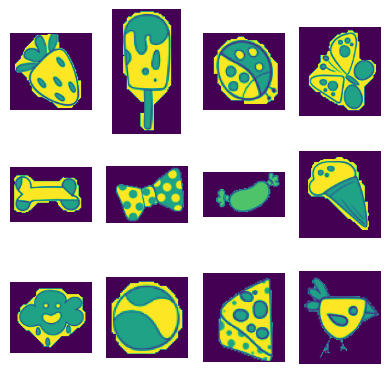

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [78]:
gray_rmbg_templates_2 = convert_color(removed_bg_templates_2, cv2.COLOR_BGR2GRAY)
show_images(gray_rmbg_templates_2, plot_size=(3, 4), figsize=(4, 4))
gray_rmbg_templates_2[0]

In [130]:
def _prepare_template_and_mask(template, img_color_space):
    """
    Nếu ảnh gốc là grayscale thì chuyển template sang gray.
    Ngược lại vẫn dùng template gốc, đồng thời tạo mask bằng ngưỡng trên ảnh gray.
    """
    # Nếu ảnh gốc là gray
    if img_color_space == 'gray':
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        template_used = template_gray
    else:
        # Ảnh gốc là color
        template_used = template
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # Tạo mask foreground bằng threshold
    _, mask = cv2.threshold(template_gray, 5, 255, cv2.THRESH_BINARY)
    return template_used, mask

def _search_best_scale(img, template_used, mask, method, scales):
    """
    Duyệt qua các 'scales' để resize template và mask,
    trả về (best_loc, best_scale, best_min_val, best_max_val).
    """
    h, w = template_used.shape[:2]

    # Xác định kiểu so khớp “tốt nhất”
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        best_val = float('inf')
    else:
        best_val = float('-inf')

    best_loc = None
    best_scale = None
    best_min_val = None
    best_max_val = None

    for scale in tqdm(scales, unit='scale', desc='\t'):
        new_h, new_w = int(h * scale), int(w * scale)
        # Bỏ qua scale nếu template bị co về kích thước <= 0
        if new_h < 1 or new_w < 1:
            continue

        template_resized = cv2.resize(template_used, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        mask_resized = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

        # Nếu sử dụng TM_SQDIFF hoặc TM_CCORR, ta mới được phép dùng mask
        if method in [cv2.TM_SQDIFF, cv2.TM_CCORR]:
            res = cv2.matchTemplate(img, template_resized, method, mask=mask_resized)
        else:
            res = cv2.matchTemplate(img, template_resized, method)

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        # Cập nhật best_val, best_loc, v.v... tùy theo phương pháp
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            if min_val < best_val:
                best_val = min_val
                best_loc = min_loc
                best_scale = scale
                best_min_val = min_val
                best_max_val = max_val
        else:
            if max_val > best_val:
                best_val = max_val
                best_loc = max_loc
                best_scale = scale
                best_min_val = min_val
                best_max_val = max_val

    return best_loc, best_scale, best_min_val, best_max_val

def _compute_bounding_box(best_loc, best_scale, w, h):
    """
    Tính toạ độ góc trên - trái và dưới - phải cho bounding box dựa trên best_scale.
    """
    top_left = best_loc
    h_resize = int(h * best_scale)
    w_resize = int(w * best_scale)
    bottom_right = (top_left[0] + w_resize, top_left[1] + h_resize)
    return top_left, bottom_right

def template_matching_best_scale(templates, img, meth, scales):
    """
    Thực hiện Template Matching với nhiều scale khác nhau trên danh sách template.

    Args:
        templates (list of np.ndarray): Danh sách các template cần tìm trên ảnh.
        img (np.ndarray): Ảnh gốc để thực hiện template matching.
        meth (str): Tên phương pháp template matching, ví dụ "TM_CCOEFF_NORMED".
        scales (list of float): Danh sách tỉ lệ scale để resize (vd: [0.5, 1.0, 1.5]).

    Returns:
        list of dict: Mỗi phần tử chứa thông tin bounding box:
        {
            "top_left": (x, y),
            "bottom_right": (x, y),
            "min_val": float,
            "max_val": float,
            "best_value": float,
            "method": str
        }
    """

    # Xác định kiểu ảnh gốc (color hoặc gray)
    img_color_space = 'rgb' if len(img.shape) > 2 else 'gray'
    method = getattr(cv2, meth)

    results = []
    for i, template in enumerate(templates):
        print(f'Template {i + 1}/{len(templates)}')

        # Chuẩn bị template và mask
        template_used, mask = _prepare_template_and_mask(template, img_color_space)

        # Tìm best_loc, best_scale
        best_loc, best_scale, best_min_val, best_max_val = _search_best_scale(
            img, template_used, mask, method, scales
        )

        # Tính bounding box
        h, w = template_used.shape[:2]
        top_left, bottom_right = _compute_bounding_box(best_loc, best_scale, w, h)

        # Xác định best_value
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            best_value = best_min_val
        else:
            best_value = best_max_val

        # Lưu dict kết quả
        results.append({
            "top_left": top_left,
            "bottom_right": bottom_right,
            "min_val": best_min_val,
            "max_val": best_max_val,
            "best_value": best_value,
            "method": meth
        })

    return results

4
Template 1/15


	: 100%|██████████| 4/4 [00:00<00:00, 16.20scale/s]


Template 2/15


	: 100%|██████████| 4/4 [00:00<00:00, 13.06scale/s]


Template 3/15


	: 100%|██████████| 4/4 [00:00<00:00, 16.61scale/s]


Template 4/15


	: 100%|██████████| 4/4 [00:00<00:00, 14.86scale/s]


Template 5/15


	: 100%|██████████| 4/4 [00:00<00:00, 19.02scale/s]


Template 6/15


	: 100%|██████████| 4/4 [00:00<00:00, 18.41scale/s]


Template 7/15


	: 100%|██████████| 4/4 [00:00<00:00, 18.10scale/s]


Template 8/15


	: 100%|██████████| 4/4 [00:00<00:00, 14.11scale/s]


Template 9/15


	: 100%|██████████| 4/4 [00:00<00:00, 13.87scale/s]


Template 10/15


	: 100%|██████████| 4/4 [00:00<00:00, 14.88scale/s]


Template 11/15


	: 100%|██████████| 4/4 [00:00<00:00, 14.47scale/s]


Template 12/15


	: 100%|██████████| 4/4 [00:00<00:00, 16.33scale/s]


Template 13/15


	: 100%|██████████| 4/4 [00:00<00:00, 16.96scale/s]


Template 14/15


	: 100%|██████████| 4/4 [00:00<00:00, 12.37scale/s]


Template 15/15


	: 100%|██████████| 4/4 [00:00<00:00, 17.89scale/s]


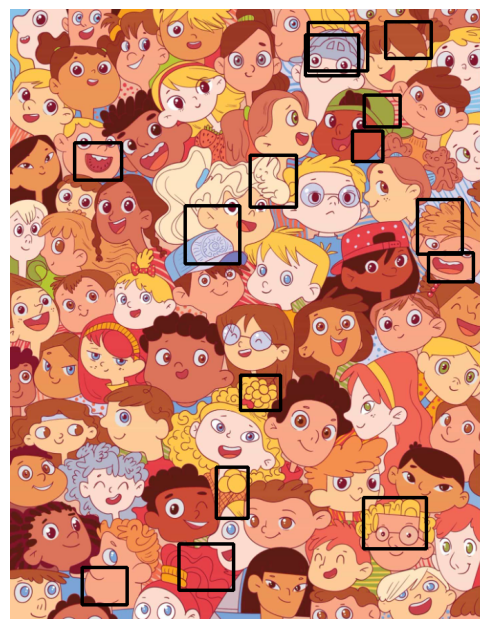

In [131]:
scales = np.arange(1.0, 0.6, -0.1)
print(len(scales))

methods = [
    "TM_SQDIFF"
]

img_res = image_1.copy()
results = []
for i, method in enumerate(methods):
    match_result = template_matching_best_scale(templates=removed_bg_templates_1_1, meth=method, img=image_1, scales=scales)
    img_res = draw_bounding_box(image_1, match_result)
    results.append(img_res)
    
show_images(results, figsize=(5, 9))

Template 1/15


	: 100%|██████████| 4/4 [00:00<00:00, 16.34scale/s]


Template 2/15


	: 100%|██████████| 4/4 [00:00<00:00, 13.18scale/s]


Template 3/15


	: 100%|██████████| 4/4 [00:00<00:00, 15.93scale/s]


Template 4/15


	: 100%|██████████| 4/4 [00:00<00:00, 14.43scale/s]


Template 5/15


	: 100%|██████████| 4/4 [00:00<00:00, 19.69scale/s]


Template 6/15


	: 100%|██████████| 4/4 [00:00<00:00, 19.14scale/s]


Template 7/15


	: 100%|██████████| 4/4 [00:00<00:00, 18.88scale/s]


Template 8/15


	: 100%|██████████| 4/4 [00:00<00:00, 14.35scale/s]


Template 9/15


	: 100%|██████████| 4/4 [00:00<00:00, 14.44scale/s]


Template 10/15


	: 100%|██████████| 4/4 [00:00<00:00, 15.45scale/s]


Template 11/15


	: 100%|██████████| 4/4 [00:00<00:00, 14.96scale/s]


Template 12/15


	: 100%|██████████| 4/4 [00:00<00:00, 16.61scale/s]


Template 13/15


	: 100%|██████████| 4/4 [00:00<00:00, 16.59scale/s]


Template 14/15


	: 100%|██████████| 4/4 [00:00<00:00, 13.49scale/s]


Template 15/15


	: 100%|██████████| 4/4 [00:00<00:00, 18.09scale/s]


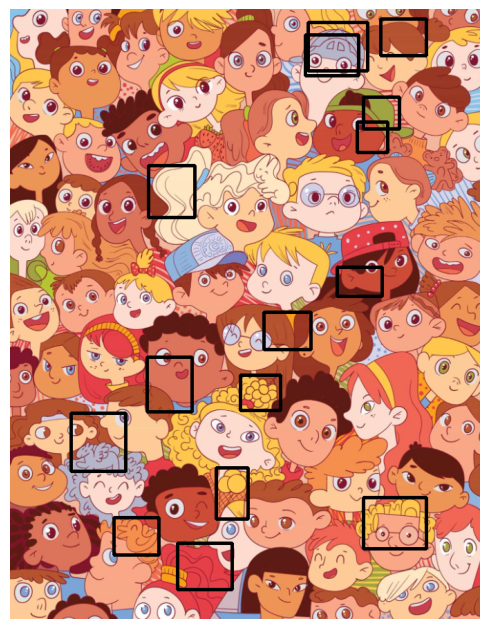

In [132]:
img_res = image_1.copy()
results = []
for i, method in enumerate(methods):
    match_result = template_matching_best_scale(templates=removed_bg_templates_1_2, meth=method, img=image_1, scales=scales)
    img_res = draw_bounding_box(image_1, match_result)
    results.append(img_res)
    
show_images(results, figsize=(5, 9))